<a href="https://colab.research.google.com/github/nlahri/Energy_Consumption_Prediction/blob/main/Energy_consumption_modular_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction and Problem Statement**




This project's objective is to utilize time series forecasting to predict the hourly energy consumption for a city in Morocco called Tétouan.

**Dateset:** The dataset we are using is related to the power consumption of three different distribution networks in Tétouan, located in northern Morocco. The power consumption data for this project is collected and provided by Amendis, a public service operator, through their Supervisory Control and Data Acquisition System (SCADA). The distribution network in Tétouan is powered by three zone stations: Quads, Smir, and Boussafou. Each of these stations supplies power to different areas of the city, creating three distinct target variables. The dataset comprises 52,416 energy consumption observations recorded in 10-minute intervals, spanning from January 1st, 2017, to December 30th, 2017. We focused on one distribution network for our analysis, choosing the one with the highest consumption to align with the area coverage.

**Problem statement:**
The problem we aim to address is twofold. First, given that Morocco heavily relies on non-renewable energy sources (64%), forecasting energy consumption can assist stakeholders in managing energy purchases and stock more effectively. Second, while Morocco plans to cut down on energy imports by boosting production from renewable sources, these sources, such as wind and solar, are not available consistently throughout the year. By comprehensively understanding the energy demands of the country, starting with Tétouan, we can better strategize and allocate these resources. Additionally, accurate forecasting can help mitigate the energy imbalance between generation and consumption, ensuring that vital resources are used efficiently and sustainably.

In a real-world scenario, the findings from this project could be instrumental for energy planners and policymakers. Accurate energy consumption forecasts would enable more efficient energy resource management, maintain the supply and demand equilibrium, and support the integration of renewable energy into the grid. This could lead to cost savings, improved energy security, and a more resilient power system for Morocco.


# **Literature Review and Related Work**

### Time Series Forecasting with Machine Learning
**Author:** Rob Mulla  
**Platform:** [Kaggle](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt)

We implemented Rob Mulla's Kaggle resource for exploratory data analysis. It provided techniques for visualizing power consumption against the index date-time. We also utilized these techniques to understand how external factors such as temperature and humidity change over time, and how they might influence energy consumption. Although the code provided is concise, it served as a valuable guide in our exploratory process, helping us understand the relationships between various factors and power consumption.


### Time Series Forecasting on Power Consumption
**Author:** Giovanni Valdata  
**Platform:** Towards Data Science  
**Date:** October 4, 2022

Giovanni Valdata’s blog post on "Time Series Forecasting on Power Consumption" offers valuable insights into the power consumption data for Tétouan, Morocco. This article not only provides background information about the dataset but also guides readers on how to load and access the data effectively. Valdata references a Kaggle Grandmaster’s code for exploratory data analysis (EDA) to understand the relationships between features and target variables.

One key difference in our approach is in the resampling of data. While the blog makes predictions every 10 minutes, we have aggregated the data to an hourly frequency. This involves calculating the mean for each hour for environmental variables like temperature, humidity, and wind speed, and summing the power consumption data to convert it to kilowatts. This aggregated approach allows us to capture a comprehensive view of both power consumption and environmental conditions on an hourly basis. Additionally, the blog summed up the target variable for the three zones, while we focused on one zone, the zone with the highest power consumption.

We also performed feature importance analysis similar to the blog, understanding which features are significant in predicting energy consumption. However, we differed by running various models with changing exogenous variables to see the impact. The article used gradient boosting with XGBoost for the forecasting model, while we employed LightGBM for gradient boosting. Overall, the article provided us with valuable insights into the data and its background, but we utilized our modeling techniques and relatively adjusted datasets in both the date-time and target variables.

### SKForecast Documentation
**Website:** [SKForecast User Guides](https://skforecast.org/0.13.0/user_guides/user-guides)  
**Authors:** Joaquín Amat Rodrigo, Javier Escobar Ortiz

The user guide of the SKForecast documentation was utilized to implement various models for our analysis. For model training, we adopted the main libraries and techniques for test-train selection and model training from the documentation. However, we developed a custom function to explore various hyperparameter tuning and exogenous variable scenarios. This approach allowed us to predict and plot results, calculate root mean squared error (RMSE), and optionally plot residuals. By employing this custom function, we could effectively compare the performance of different models and improve our forecasting accuracy.

# **Data Preparation Based on Exploratory Analysis**

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.dates as mdates


In [ ]:
# reading data from the site
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv')

In [ ]:
# Cleaning dataframes based on EDA

#Rename columns
df = df.rename(columns={"Zone 1 Power Consumption": "Z1 Power",
                        "Zone 2  Power Consumption": "Z2 Power",
                        "Zone 3  Power Consumption": "Z3 Power",
                        })

# Its efficient and convinient to use datatime as index when dealing with timeseries data
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

# Converting data to per hour from per 10 minutes
df_exg = df.resample('H').mean()
df_ts = df.resample('H').sum().div(1000)

df = pd.concat([df_ts[['Z1 Power', 'Z2 Power', 'Z3 Power']], df_exg[['Temperature', 'Humidity', 'Wind Speed']]], axis=1)
df.head()

,Z1 Power,Z2 Power,Z3 Power,Temperature,Humidity,Wind Speed
DateTime,,,,,,
2017-01-01 00:00:00,175.187848,108.160486,115.512289,6.196833,75.066667,0.081833
2017-01-01 01:00:00,147.943291,96.470517,102.257349,5.548833,77.583333,0.082000
2017-01-01 02:00:00,132.498228,85.984195,94.056867,5.054333,78.933333,0.082333
2017-01-01 03:00:00,124.866835,79.316717,89.303133,5.004333,77.083333,0.082833
2017-01-01 04:00:00,122.855696,77.529483,85.902651,5.097667,74.050000,0.082333


## Feature Engineering

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df
df = create_features(df)

## Verifying Data Sanity

Before proceding to model fitting, checking the dataframe is as expected.

In [ ]:
# Verifying Data looks as expected before proceeding further
print(df.shape)
df.describe()

(8736, 8)


,Z1 Power,Z2 Power,Z3 Power,Temperature,Humidity,Wind Speed,hour,dayofweek
count,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000
mean,194.069823,126.255054,107.012437,18.810024,68.259518,1.959489,11.500000,3.000000
std,42.413519,30.991069,39.546084,5.807624,15.475739,2.340551,6.922583,2.000114
min,85.974684,52.115682,37.143818,3.602167,12.710000,0.054667,0.000000,0.000000
25%,157.757710,102.101410,78.890821,14.403750,58.324583,0.078167,5.750000,1.000000
50%,194.053820,124.723377,98.565958,18.759167,69.815833,0.085500,11.500000,3.000000
75%,223.908013,148.065654,129.590687,22.866667,81.350000,4.915333,17.250000,5.000000
max,311.065572,217.528194,283.342594,39.695000,94.750000,5.933667,23.000000,6.000000


In [ ]:
df.head()

,Z1 Power,Z2 Power,Z3 Power,Temperature,Humidity,Wind Speed,hour,dayofweek
DateTime,,,,,,,,
2017-01-01 00:00:00,175.187848,108.160486,115.512289,6.196833,75.066667,0.081833,0,6
2017-01-01 01:00:00,147.943291,96.470517,102.257349,5.548833,77.583333,0.082000,1,6
2017-01-01 02:00:00,132.498228,85.984195,94.056867,5.054333,78.933333,0.082333,2,6
2017-01-01 03:00:00,124.866835,79.316717,89.303133,5.004333,77.083333,0.082833,3,6
2017-01-01 04:00:00,122.855696,77.529483,85.902651,5.097667,74.050000,0.082333,4,6


# **Methodology: Model fitting**

### Import libraries

In [ ]:
%%capture
!pip install skforecast
!pip install pmdarima

In [ ]:

# Baseline model
from skforecast.ForecasterBaseline  import ForecasterEquivalentDate

# model
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster, grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
from lightgbm import LGBMRegressor
from skforecast.plot import plot_residuals

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import mean_absolute_error, mean_squared_error

#nltd: clean this

## Train-Test Split

Taking data from Jan 01 2017 to  Dec 01 2017 as traing for model and beyond Dec 01 2017 for testing of forecast

Train dates : 2017-01-01 00:00:00 --- 2017-12-01 23:00:00  (n=8040)
Test dates  : 2017-12-01 23:00:00 --- 2017-12-30 23:00:00  (n=697)
(8040,) (696,) (8040, 5) (696, 5)


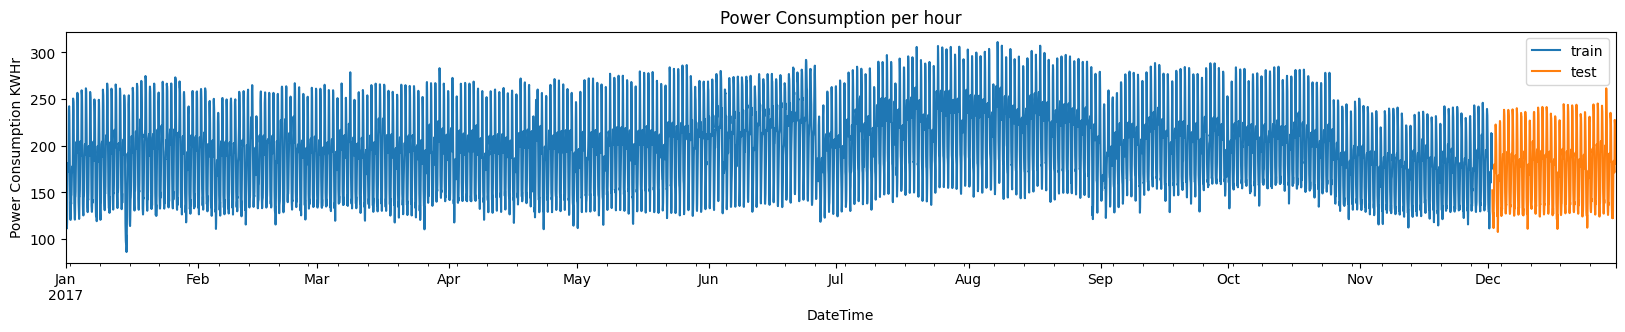

In [ ]:
end_train = '2017-12-01 23:00:00'

print(
    f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  "
    f"(n={len(df.loc[:end_train])})"
)
print(
    f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[end_train:])})"
)
data_train = df.loc[:end_train]['Z1 Power']
data_test  = df.loc[end_train:]['Z1 Power']

cols = ['Temperature', 'Humidity', 'Wind Speed', 'hour','dayofweek']
data_train_exog = df.loc[:end_train][cols]
data_test_exog  = df.loc[end_train:][cols]


# removing the reated row in test and train data
data_test = data_test.iloc[1:]
data_test_exog = data_test_exog.iloc[1:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(20, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Power Consumption per hour')
ax.set_ylabel('Power Consumption KWHr')
ax.legend();

print(data_train.shape, data_test.shape, data_train_exog.shape, data_test_exog.shape)

## Modular function to fit, predict and plot model output.

Advantages of modular function:
1. Avoid repeatation of code
2. Easiy to maintain and make incremental changes during analysis
3. Help is maintaining uniformaty in plots

In [ ]:
def model_predict_plot(model, data_train, data_test, data_train_exog=None, data_test_exog=None, include_exog = False, create_plot_residuals= False, model_name = ""):
  y_pred = None
  if include_exog and data_train_exog is not None:
    y_pred = model.predict(steps=len(data_test), exog=data_test_exog)

  else:
    y_pred = model.predict(steps=len(data_test))


  y_pred.columns = [model_name]
  fig, ax = plt.subplots(figsize=(15, 3))
  #data_train.plot(ax=ax, label='train')
  data_test.plot(ax=ax, label='test')
  y_pred.plot(ax=ax, label=model_name)
  ax.set_title(f"Prediction for {model_name}")
  ax.legend();

  rmse = np.sqrt(mean_squared_error(data_test, y_pred))
  print(f"Root Mean Squared Error (RMSE): {rmse:.1f}")
  mae = mean_absolute_error(data_test, y_pred)
  print(f"Mean Absolute Error (MAE): {mae:.1f}")


  # Plot residuals
  if create_plot_residuals:
    residuals = y_pred - data_test
    _ = plot_residuals(residuals=residuals, figsize=(15, 3.5))

  return model


In [ ]:
def model_fit_predict_plot(model, data_train, data_test, data_train_exog=None, data_test_exog=None, include_exog = False, create_plot_residuals= False, model_name = ""):
  y_pred = None
  if include_exog and data_train_exog is not None:
    model.fit(y=data_train, exog=data_train_exog)
  else:
    model.fit(data_train)

  model_predict_plot(model, data_train, data_test, data_train_exog, data_test_exog, include_exog, create_plot_residuals, model_name=model_name )


  return model


## **Baseline model**

Taking the value for correponding hours from last day. Its good baseline model simple, straightforward and performs decently.


Root Mean Squared Error (RMSE): 17.4
Mean Absolute Error (MAE): 14.0


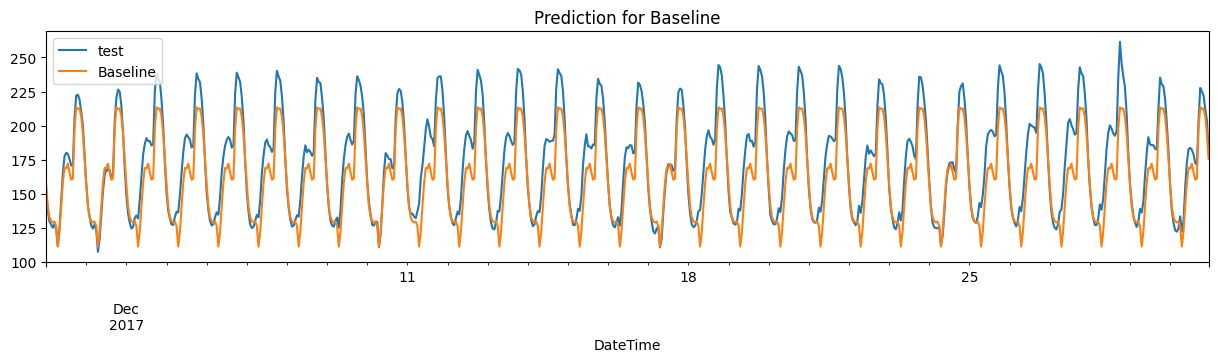

In [ ]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

model = model_fit_predict_plot(forecaster, data_train, data_test, model_name = "Baseline")

## **Forecasting Models**

### Model ARIMA with seasonality.

EDA sheet the ACF plots and PACF plot based on which p,q,d and seasonality of the ARIMA model was selcted.

Root Mean Squared Error (RMSE): 14.7
Mean Absolute Error (MAE): 12.6


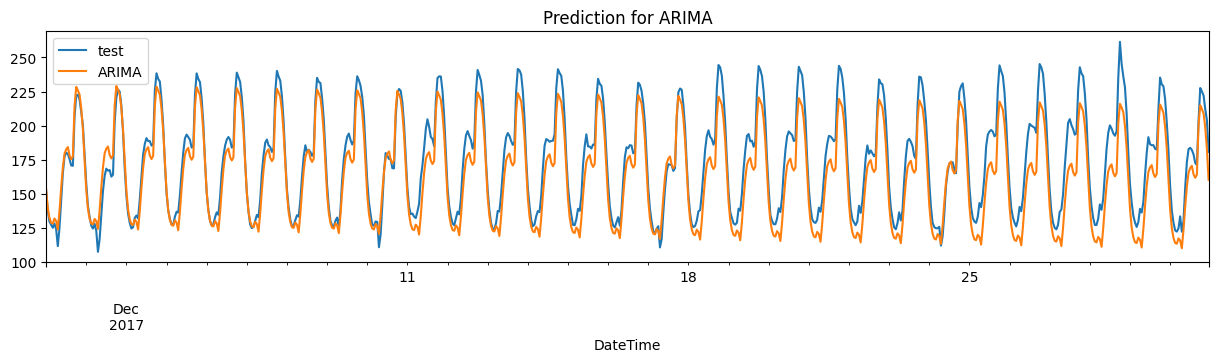

In [ ]:
# Fitting a ARIMA model with Seasonality Term

warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
arima2 = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model = model_fit_predict_plot(arima2, data_train, data_test, model_name = "ARIMA")


### Light GBM on differenced series

**Observation:** forecast is good for short horizon of 1-2 days but error get bigger for longer hosizons.

Root Mean Squared Error (RMSE): 109.5
Mean Absolute Error (MAE): 101.0


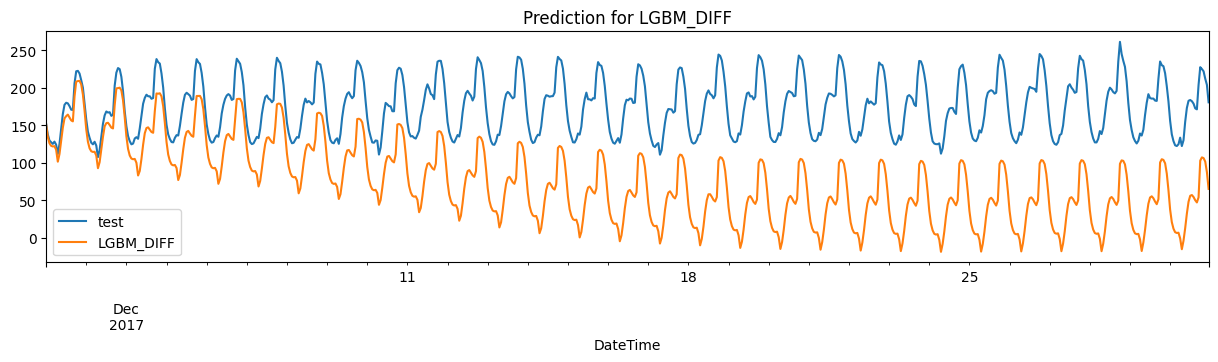

In [ ]:
# Fitting light LightGBM  on difference sereis without tuning

forecaster = ForecasterAutoreg(
                 regressor       = LGBMRegressor(random_state=123, verbose=-2),
                 lags            = 24,
                 differentiation = 1
             )
model = model_fit_predict_plot(forecaster, data_train, data_test, model_name = "LGBM_DIFF")


### Light GBM on differenced series with all Exogenous variables

**Observation:** Forecast is good for short horizon of 1-2 days but error increases for longer horizons. Differenced series is not the right way to make the forecasting model, and Since we are using a tree based model, Light GBM, the non-statianarity of the actual series is not going to be an issue, hence proceeding with actual series.

Root Mean Squared Error (RMSE): 156.6
Mean Absolute Error (MAE): 144.0


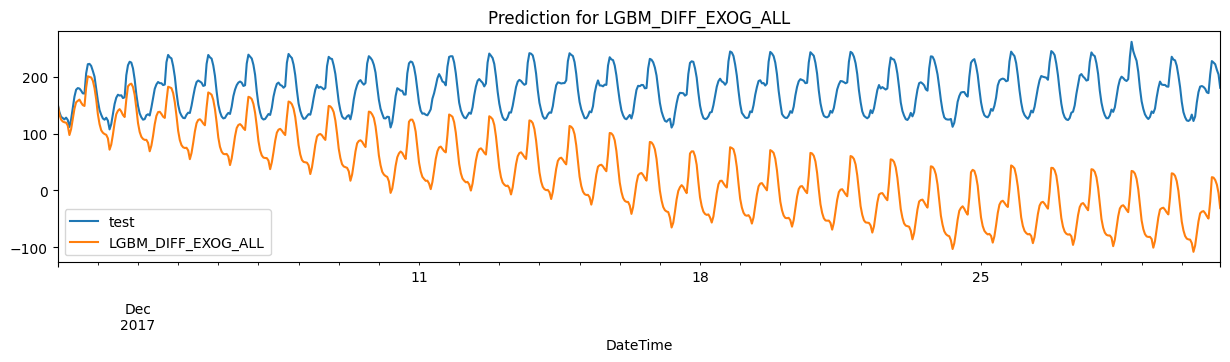

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24, differentiation = 1)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog,  data_test_exog, include_exog=True,  model_name = "LGBM_DIFF_EXOG_ALL")


### Light GBM on actual series

**Observation:** The model outperforms the baseline, though it tends to underestimate consumption during peak hours, resulting in higher error rates at these times. The distribution of residuals is positively skewed, indicating a tendency to underpredict. Feature importance analysis highlights that the closest lags, such as 1, 2, 3, 24, and 23 hours, are the most significant predictors of energy consumption.


Root Mean Squared Error (RMSE): 13.3
Mean Absolute Error (MAE): 10.5


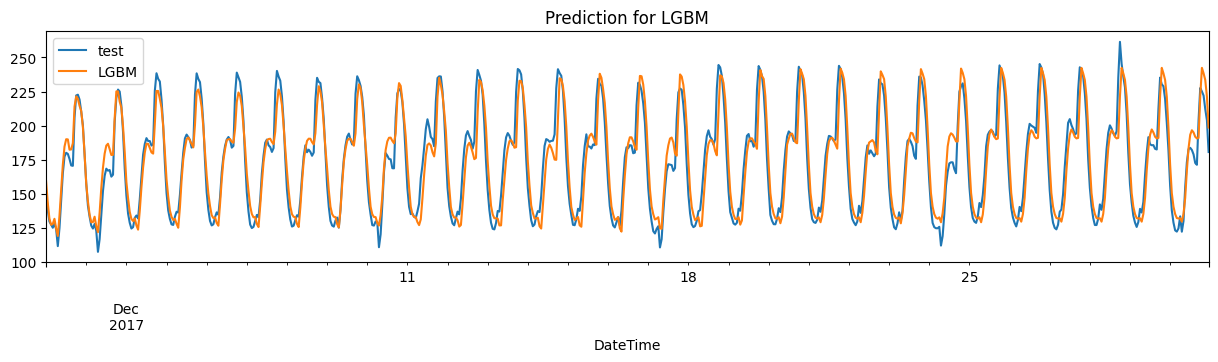

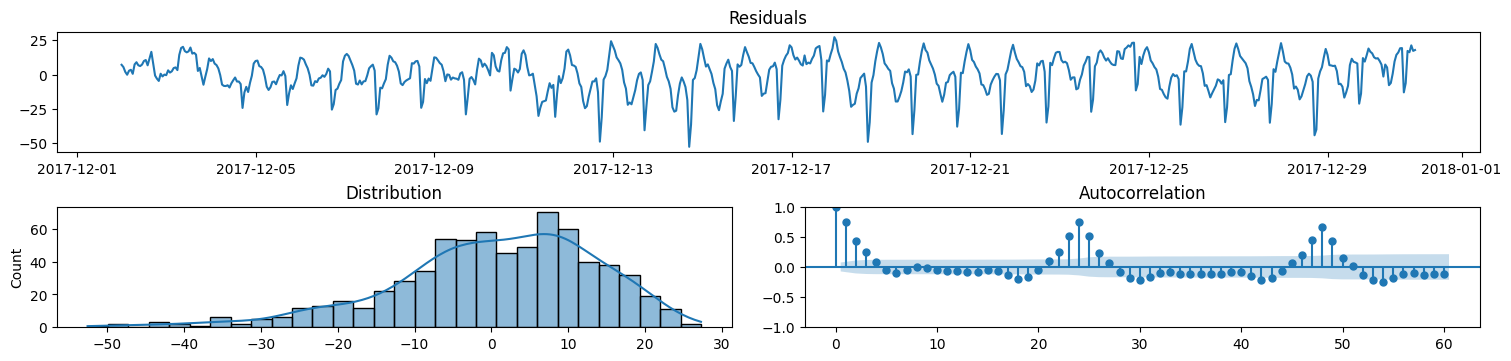

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test,create_plot_residuals= True, model_name = "LGBM")

In [ ]:
model.get_feature_importances()[:5]

,feature,importance
0,lag_1,589
23,lag_24,439
2,lag_3,150
1,lag_2,144
21,lag_22,133


### Light GBM on actual series including all the exogeneous variables

**Observation:** Incorporating exogenous variables significantly enhanced the model's predictive performance, resulting in a notable reduction in RMSE. However, the model still tends to underestimate peak consumption levels, and the residuals exhibit autocorrelation. Feature importance analysis reveals that both the day of the week and the hour of the day rank among the top five most influential predictors.

Root Mean Squared Error (RMSE): 7.7
Mean Absolute Error (MAE): 6.0


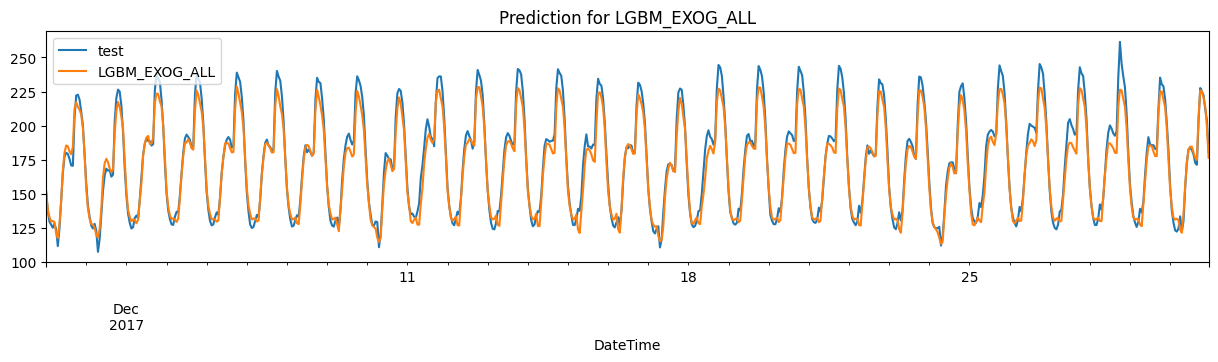

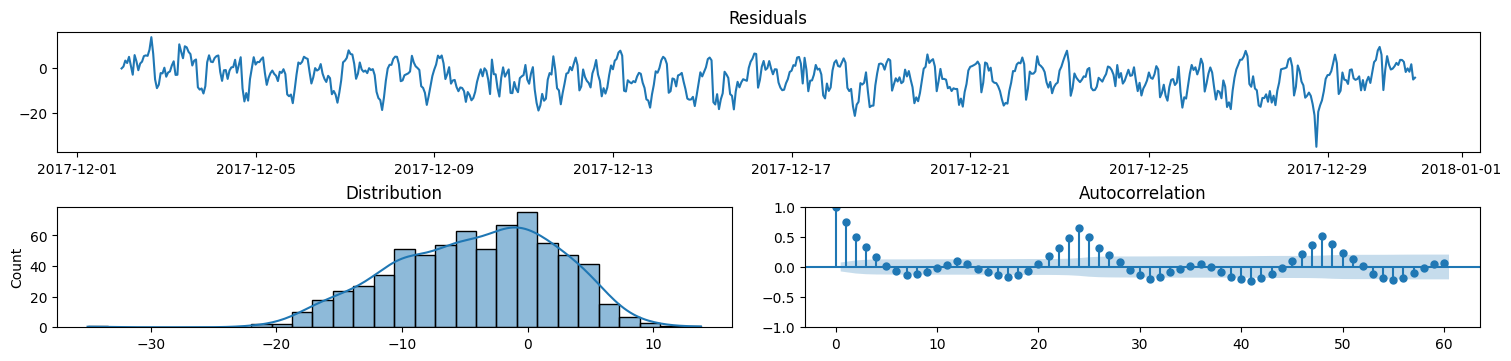

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog,  data_test_exog, include_exog=True, create_plot_residuals=True,  model_name = "LGBM_EXOG_ALL")


In [ ]:
model.get_feature_importances()[:5]

,feature,importance
0,lag_1,498
23,lag_24,360
28,dayofweek,149
27,hour,130
22,lag_23,126


### Experimenting with few of exogeneous variables

Observing the impact of including a few exogenous variables on the model prediction pattern.

**Observation:**The conclusion of this exercise is that all the exogenous variables are important and should be included in the model for optimal accuracy.

Root Mean Squared Error (RMSE): 9.8
Mean Absolute Error (MAE): 7.5


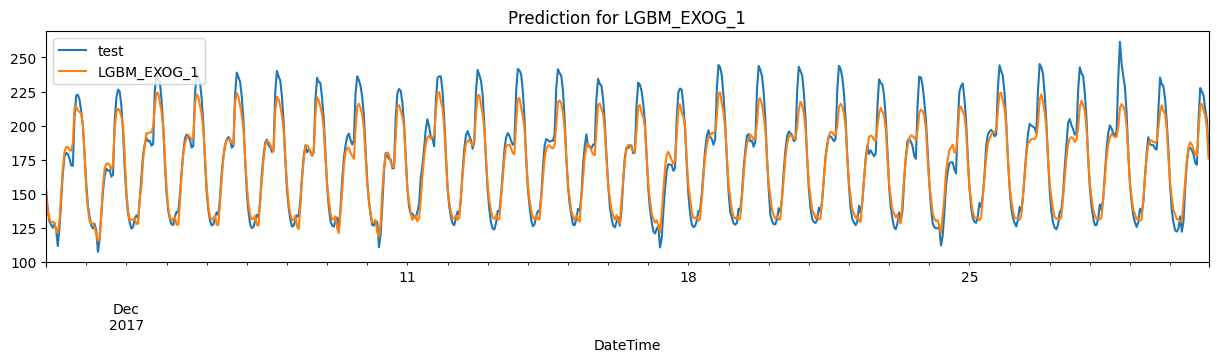

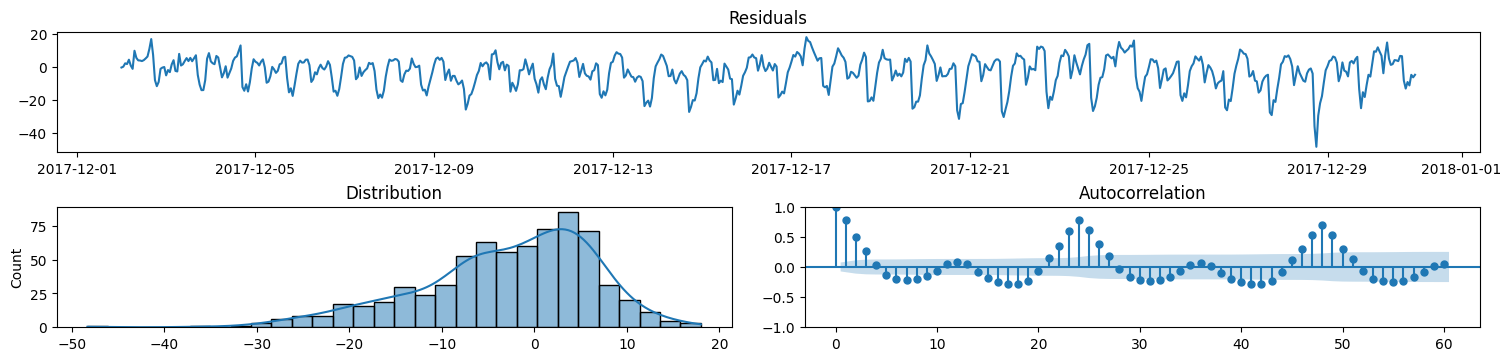

In [ ]:
exog_col = ['dayofweek', 'hour']
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog[exog_col],  data_test_exog[exog_col], include_exog=True, create_plot_residuals= True,  model_name = "LGBM_EXOG_1")


Root Mean Squared Error (RMSE): 8.7
Mean Absolute Error (MAE): 6.9


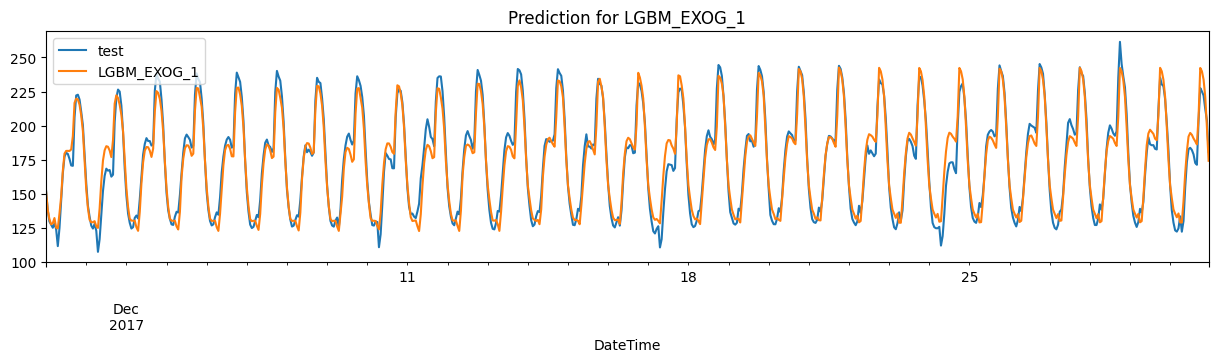

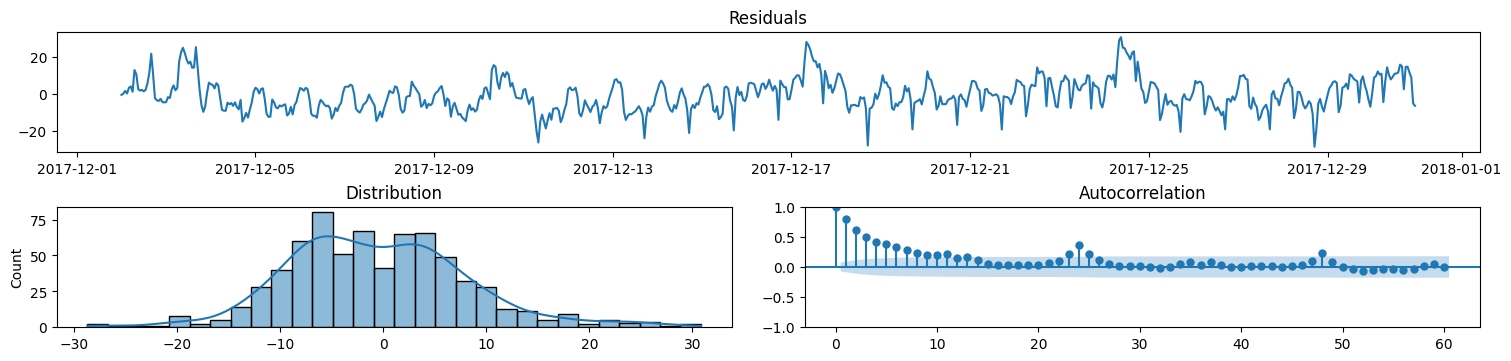

In [ ]:
exog_col = ['hour', 'Temperature']
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog[exog_col],  data_test_exog[exog_col], include_exog=True, create_plot_residuals= True,  model_name = "LGBM_EXOG_1")


Root Mean Squared Error (RMSE): 13.4
Mean Absolute Error (MAE): 10.1


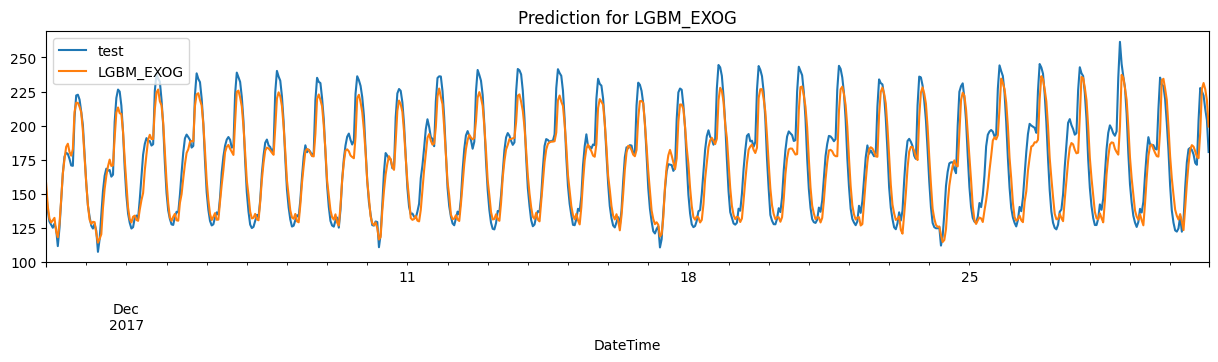

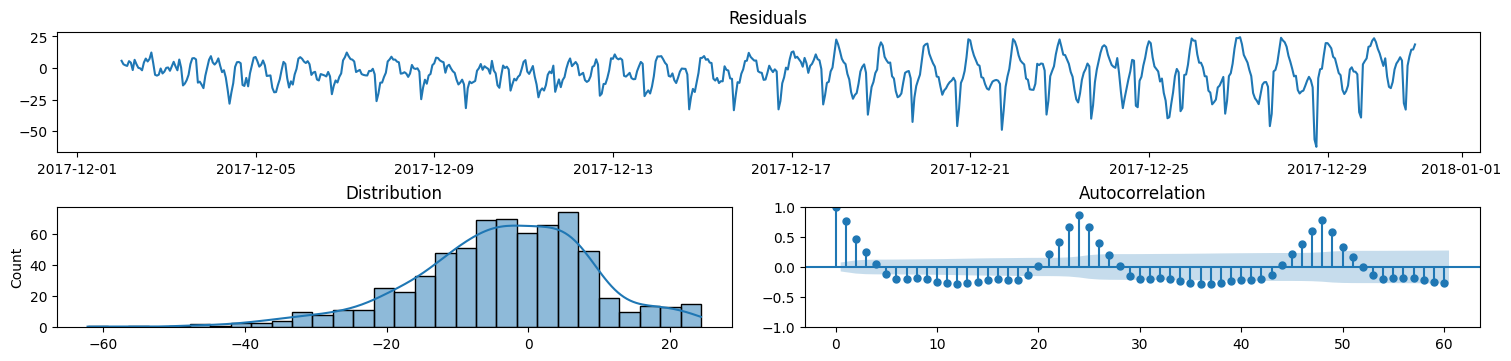

In [ ]:
exog_col = ['dayofweek','Temperature']
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog[exog_col],  data_test_exog[exog_col], include_exog=True, create_plot_residuals= True,  model_name = "LGBM_EXOG")


**Observation:** Experimented with various exogenous variables and found that using only the day of the week yielded the best results. In fact, introducing additional exogenous variables negatively impacted the model's performance, leading to a higher RMSE.


In [ ]:
model.get_feature_importances()[:5]

,feature,importance
0,lag_1,534
23,lag_24,392
24,dayofweek,144
1,lag_2,138
22,lag_23,132


**Observation:** The top five features identified are the nearest point in the 24-hour cycle and the specific time of day. This finding suggests that incorporating cyclic features for both hours and days could enhance the model's predictive power.









### Light GBM with cyclic exogenous variables


#### Adding Cyclic Feature for hour and dayofweek


Making modification to Exogeneous variable hour and dayofweek. Converting them to cycling variables to capture their cyclic nature of influence.


In [ ]:
# Cyclical encoding
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.
  """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

In [ ]:
hour_encoded = cyclical_encoding(data_train_exog['hour'], cycle_length=24)
dayofweek_encoded = cyclical_encoding(data_train_exog['dayofweek'], cycle_length=7)
data_train_exog = pd.concat([data_train_exog.drop(['dayofweek','hour'], axis =1), hour_encoded, dayofweek_encoded], axis=1)

hour_encoded = cyclical_encoding(data_test_exog['hour'], cycle_length=24)
dayofweek_encoded = cyclical_encoding(data_test_exog['dayofweek'], cycle_length=7)
data_test_exog = pd.concat([data_test_exog.drop(['dayofweek','hour'], axis =1), hour_encoded, dayofweek_encoded], axis=1)

#verify the data is correct
data_train_exog.head()

,Temperature,Humidity,Wind Speed,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
DateTime,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.000000,1.000000,-0.781831,0.62349
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.258819,0.965926,-0.781831,0.62349
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.500000,0.866025,-0.781831,0.62349
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.707107,0.707107,-0.781831,0.62349
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.866025,0.500000,-0.781831,0.62349


Root Mean Squared Error (RMSE): 6.9
Mean Absolute Error (MAE): 5.5


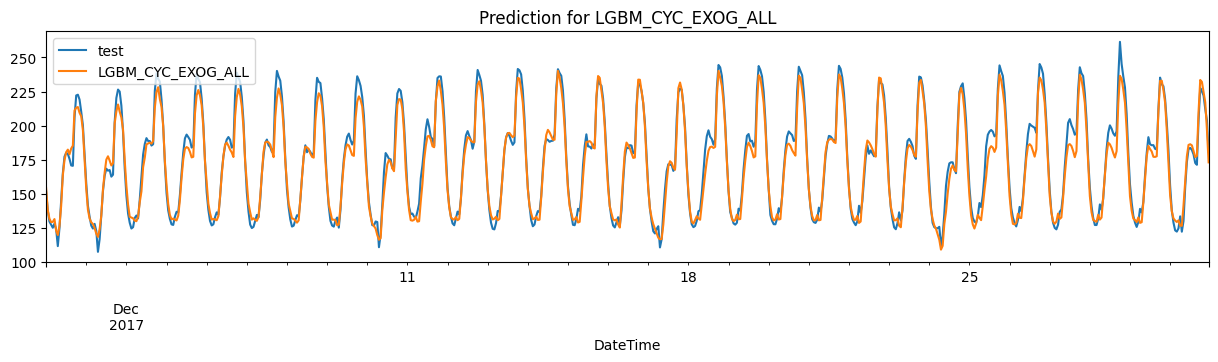

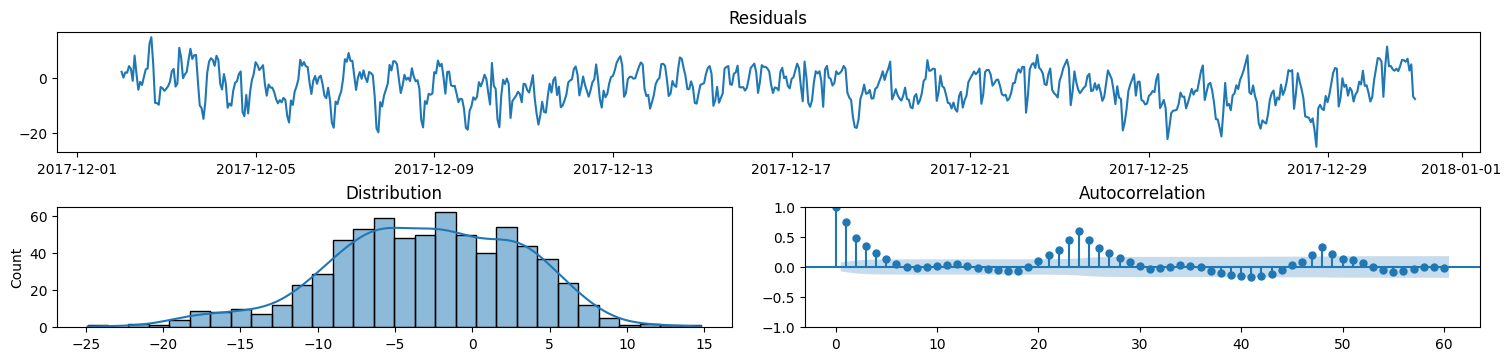

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog,  data_test_exog, include_exog=True, create_plot_residuals=True,  model_name = "LGBM_CYC_EXOG_ALL")


In [ ]:
model.get_feature_importances()[:10]

,feature,importance
0,lag_1,510
23,lag_24,342
28,hour_cos,121
21,lag_22,109
22,lag_23,107
1,lag_2,102
2,lag_3,96
13,lag_14,95
29,dayofweek_sin,95
24,Temperature,92


## **Hyperparameter Tuning**

### Tunned: Light GBM without Exogenous variables using Bayesian search


In [ ]:
# Hyper parameter tuning
from skforecast.model_selection import bayesian_search_forecaster

# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [24,48]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 600, step=100),
        'max_depth'       : trial.suggest_int('max_depth', -1, 5, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data_train, # Test data not used
    search_space       = search_space,
    steps              = len(data_test),
    refit              = False,
    metric             = 'mean_squared_error',
    initial_train_size = len(data_test),
    fixed_train_size   = False,
    n_trials           = 20, # Increase this value for a more exhaustive search
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'n_estimators': 600, 'max_depth': 5, 'min_data_in_leaf': 320, 'learning_rate': 0.4874073380243206, 'reg_alpha': 0.1, 'reg_lambda': 0.30000000000000004}
  Backtesting metric: 904.5653600665322



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Root Mean Squared Error (RMSE): 13.0
Mean Absolute Error (MAE): 9.6


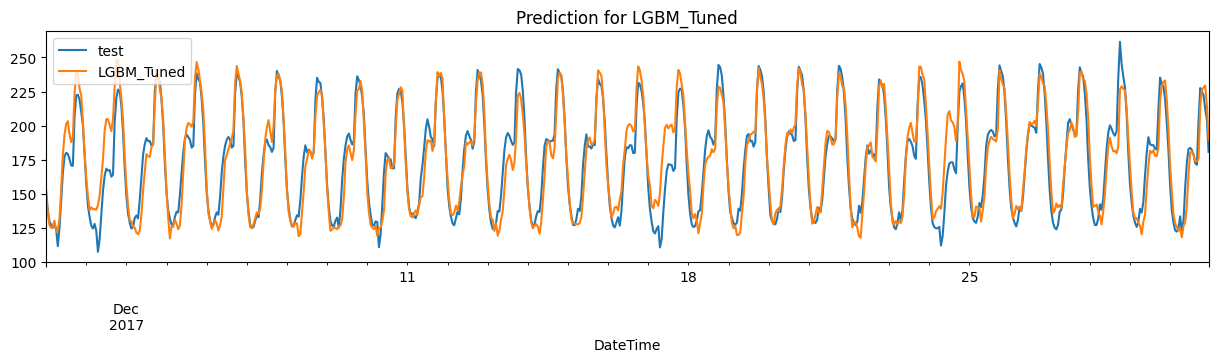

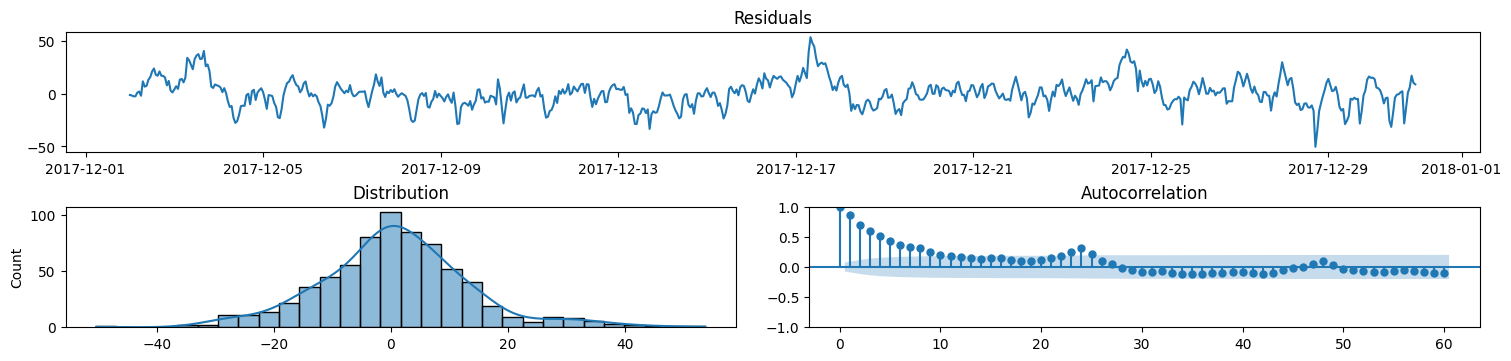

In [ ]:
model = model_predict_plot(forecaster, data_train, data_test, create_plot_residuals= True,  model_name = "LGBM_Tuned")


### Tunned: Light GBM with cyclic :Exogenous Variables using Bayesian search

**Observation:** Hyperparameter tuning is not effective because the evaluation metric is based on historical data, leading to overfitting and negatively impacting the test RMSE.

In [ ]:
# For ALL CYC EXOG

# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [24 ]

# Regressor hyperparameters search space
def search_space_exog(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 600, step=100),
        'max_depth'       : trial.suggest_int('max_depth', -1, 5, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data_train, # Test data not used
    exog              = data_train_exog,
    search_space       = search_space_exog,
    steps              = len(data_test),
    refit              = False,
    metric             =  'mean_absolute_error',
    initial_train_size = len(data_test),
    fixed_train_size   = False,
    n_trials           = 20, # Increase this value for a more exhaustive search
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 600, 'max_depth': 4, 'min_data_in_leaf': 105, 'learning_rate': 0.0880336195886509, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.2}
  Backtesting metric: 23.858850774184376



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Root Mean Squared Error (RMSE): 10.8
Mean Absolute Error (MAE): 8.5


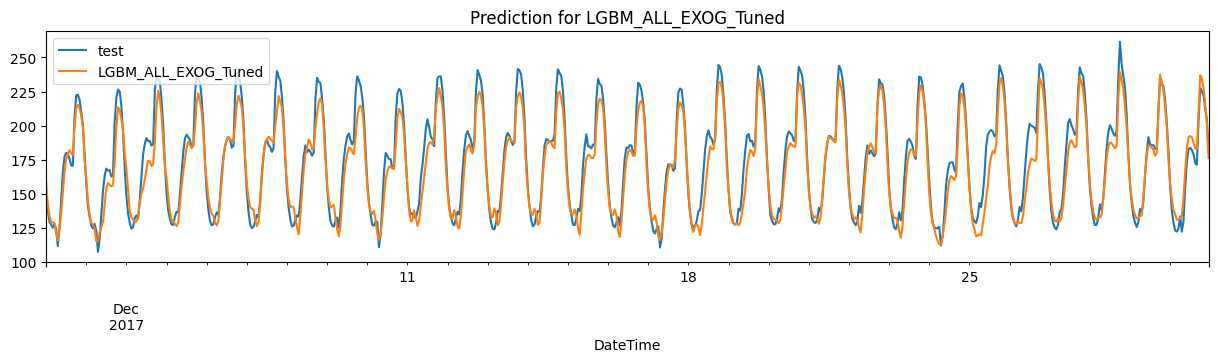

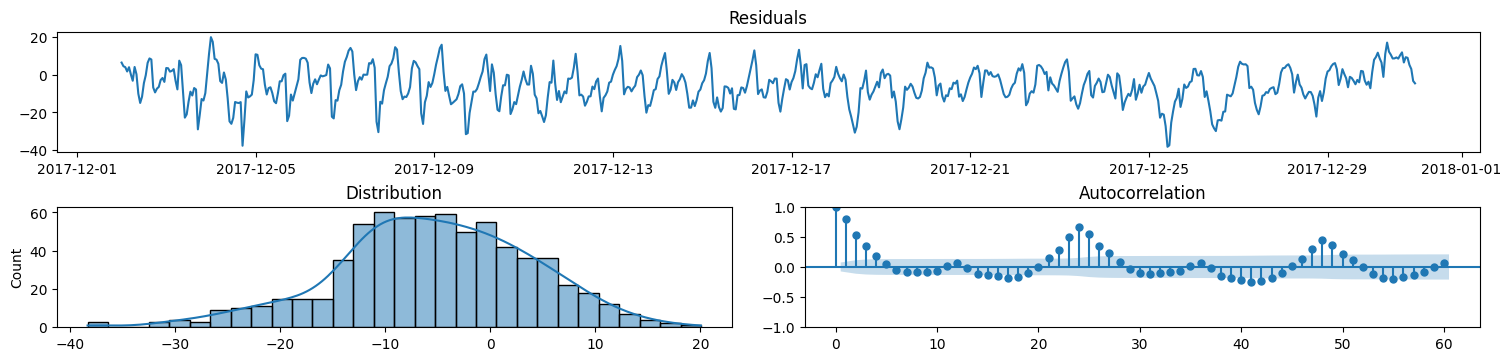

In [ ]:
model = model_predict_plot(forecaster, data_train, data_test, data_train_exog,  data_test_exog, include_exog=True, create_plot_residuals= True,  model_name = "LGBM_ALL_EXOG_Tuned")


### Tunned: Light GBM without Exgenous variables using grid search

**Observation:**
Hyperparameter tuning is not happening properly as the data evaluaton metric is based on historical data and over fitting hampeting test RMSE.

In [ ]:
# Hyperparameters search using grid search
# ==============================================================================

# Regressor hyperparameters search space
grid = {
        'n_estimators'    : [100, 300],
        'max_depth'       : [ 1,5],
        'min_data_in_leaf': [1,10, 25],
        'learning_rate'   : [ 0.1 ],

    }


forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
results_search = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = data_train, # Test data not used
    exog              = data_train_exog,
    param_grid       = grid,
    lags_grid         = [24],
    steps              = len(data_test),
    refit              = False,
    metric             =  'mean_absolute_error',
    initial_train_size = len(data_test),
    fixed_train_size   = False,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

Number of models compared: 12.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'min_data_in_leaf': 10, 'n_estimators': 100}
  Backtesting metric: 17.00633647032803



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Root Mean Squared Error (RMSE): 28.6
Mean Absolute Error (MAE): 23.6


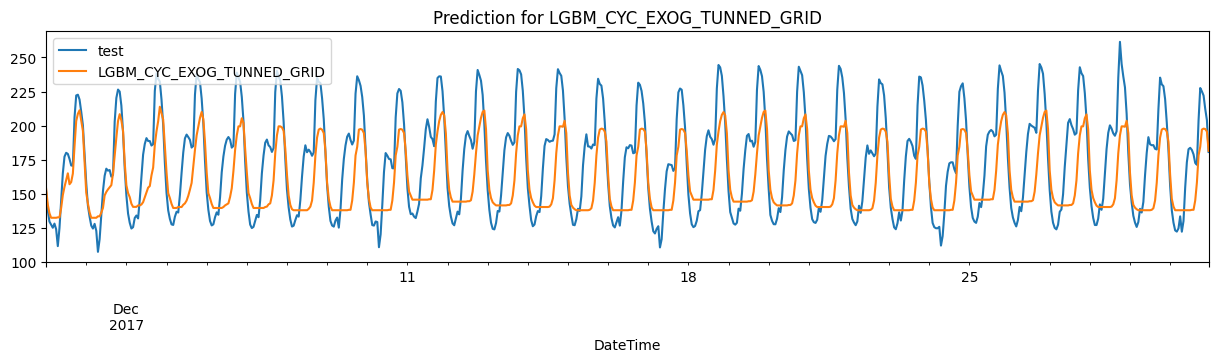

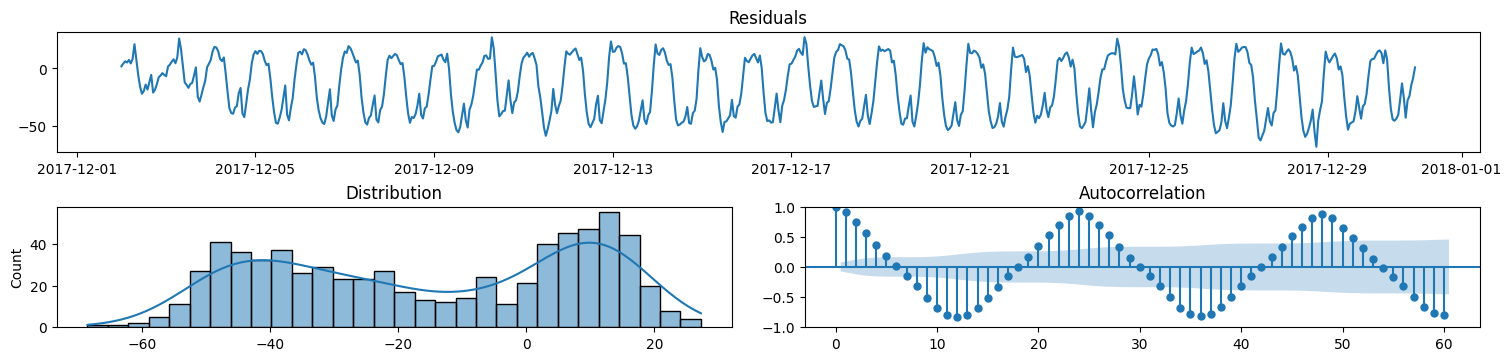

In [ ]:
model = model_predict_plot(forecaster, data_train, data_test, data_train_exog,  data_test_exog, include_exog=True, create_plot_residuals= True,  model_name = "LGBM_CYC_EXOG_TUNNED_GRID")

# Summary and Model Comparision

The table below summarizes the process of incremental changes to the model and parameters that led to the final model, "LGBM_CYC_EXOG." This model achieved an RMSE of 6.9 on the test data, a significant improvement from the baseline model, which had an RMSE of 17.4.

The percentage error for any hour is mostly less than 5%.

The final LGBM_CYC_EXOG model is trained for Zone 1 power consumption and includes all the exogenous variables: temperature, humidity, wind speed, cyclic variables for the hour, and cyclic variables for the day of the week.

Experiments revealed that all the exogenous variables play a crucial role in prediction accuracy. Removing any one of them negatively impacted the model's performance.


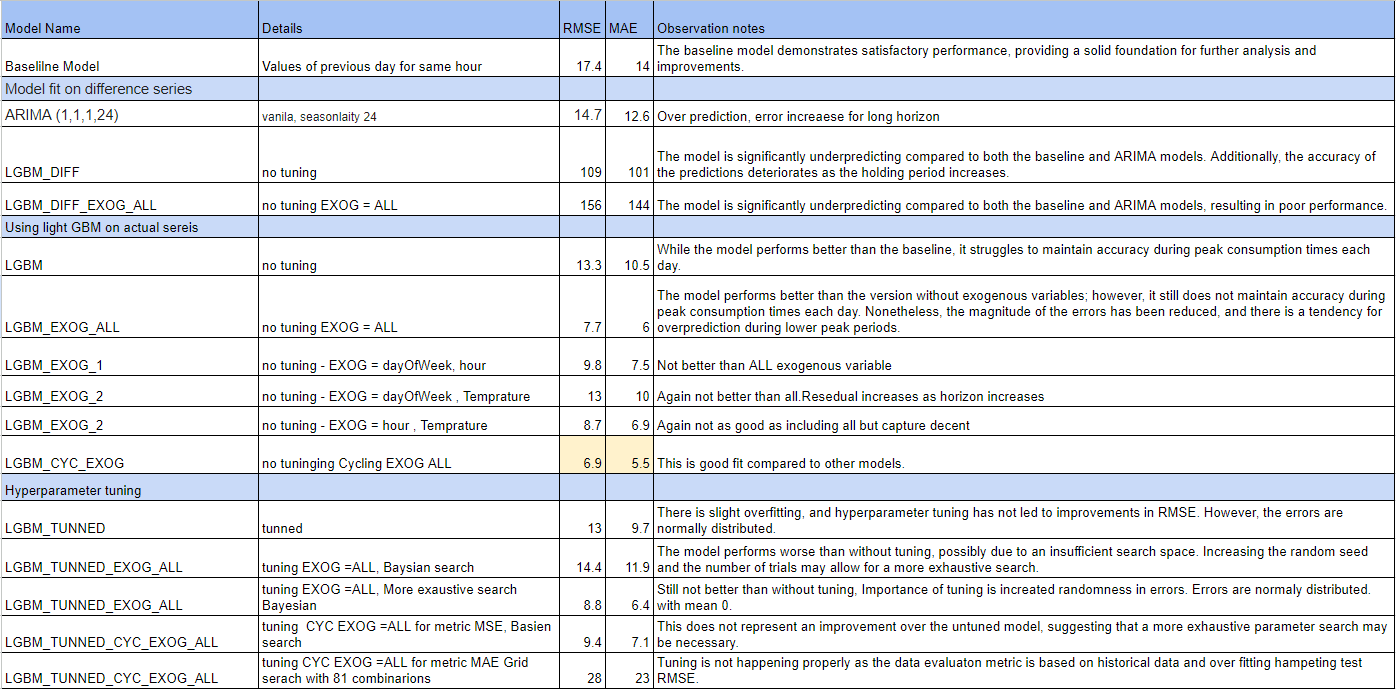

### Final Model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Root Mean Squared Error (RMSE): 6.9
Mean Absolute Error (MAE): 5.5


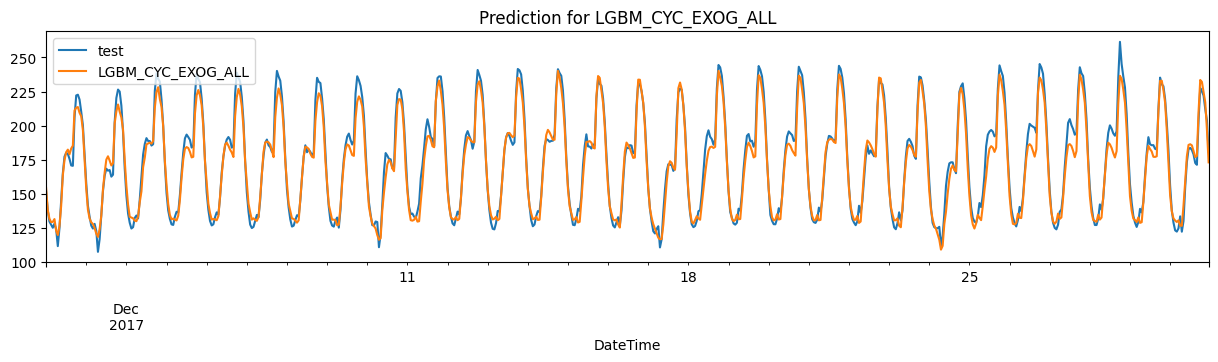

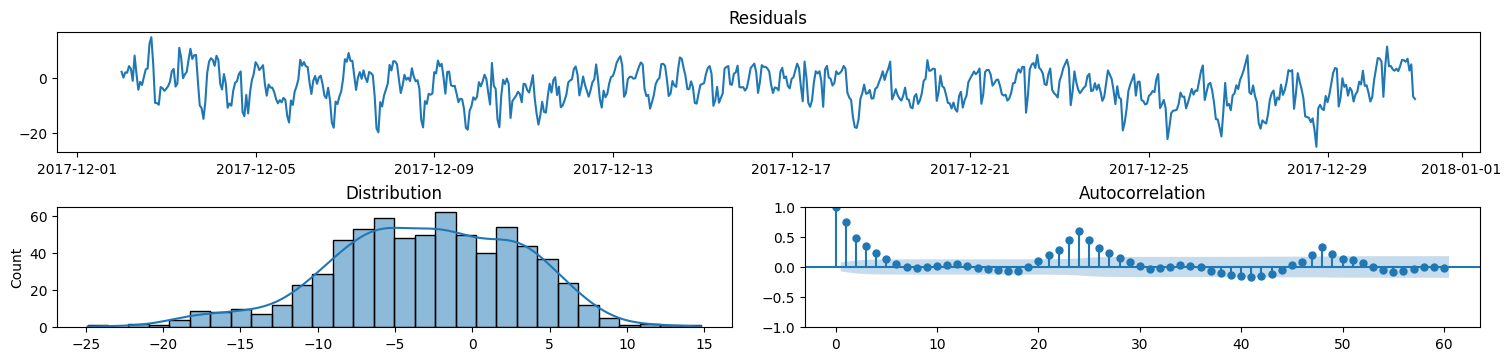

In [ ]:
# Final Model
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(random_state=123, verbose=-2),lags = 24)
model = model_fit_predict_plot(forecaster, data_train, data_test, data_train_exog,  data_test_exog, include_exog=True, create_plot_residuals=True,  model_name = "LGBM_CYC_EXOG_ALL")


### Plot percentage error in prediction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


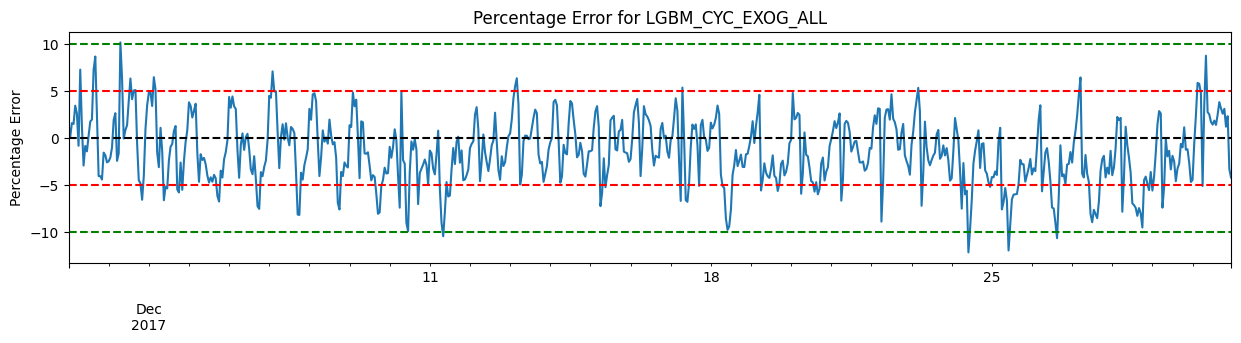

In [ ]:
model_name = "LGBM_CYC_EXOG_ALL"
y_pred  = model.predict(steps=len(data_test), exog=data_test_exog)

percentage_error = (y_pred - data_test) / data_test * 100

fig, ax = plt.subplots(figsize=(15, 3))
percentage_error.plot(ax=ax, label=model_name)

# Add horizontal lines at 5% and 10%
ax.axhline(y=0, color='black', linestyle='--', label='5% Error')

ax.axhline(y=-5, color='r', linestyle='--', label='5% Error')
ax.axhline(y=5, color='r', linestyle='--', label='5% Error')

ax.axhline(y=-10, color='g', linestyle='--', label='10% Error')
ax.axhline(y=10, color='g', linestyle='--', label='10% Error')

ax.set_title(f"Percentage Error for {model_name}")
ax.set_ylabel('Percentage Error')
#ax.legend();
plt.show()

# Challenges

1. Encountered challenges with hyperparameter tuning. The metrics used to evaluate the performance of different models during the parameter search are based on historical values, leading to models that often overfit on historical data and do not perform well on test data.
2. The residuals exhibit autocorrelation and show a clear pattern, indicating that some information has not been captured by the model. However, we do not have additional data to enhance our analysis. As a result, we must proceed with higher errors in power consumption prediction during peak periods.

# Discussion and Business Insights

The LGBM_CYC_EXOG_ALL model demonstrates high accuracy in forecasting hourly power consumption, with errors typically within the 5% range. This precision allows policymakers and power generation companies to efficiently plan power production, optimizing resource allocation and reducing reliance on non-renewable energy sources, which currently account for 64% of Morocco's energy mix. By understanding energy demands in Tétouan, stakeholders can better integrate renewable energy into the grid and strategically adjust non-renewable production to address gaps.

Accurate forecasting is essential for maintaining the balance between energy generation and consumption, as power cannot be stored in large quantities. Aligning production with actual consumption patterns minimizes unnecessary costs, especially for non-renewable sources, while improving energy security and stability. This approach not only supports cost reduction but also strengthens the overall resilience of the energy system.

The insights derived from this model can guide policy decisions regarding energy imports, investments in renewable infrastructure, and the development of smart grid technologies. The success of this model in Tétouan offers a valuable blueprint for other regions in Morocco and similar contexts worldwide, promoting sustainable energy management and operational efficiency.


# Conclusion and Area of Improvements

We have developed an effective model, LGBM_CYC_EXOG_ALL, which achieves an error rate of less than 5% for 95% of the forecasted values. However, the model encounters higher errors during peak consumption hours, which occur consistently at the same time each day. Additionally, the residuals exhibit patterns that suggest the presence of unaccounted factors in the model. Incorporating new data columns to capture these patterns presents an opportunity for further enhancement and improved accuracy in future iterations.






In [ ]:
#!pip install session_info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import session_info
session_info.show(html=False)

-----
lightgbm            4.4.0
matplotlib          3.7.1
numpy               1.26.4
optuna              3.6.1
pandas              2.1.4
pmdarima            2.0.4
seaborn             0.13.1
session_info        1.0.0
skforecast          0.13.0
sklearn             1.3.2
statsmodels         0.14.2
-----
IPython             8.12.3
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2024-08-05 23:55


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
